In [1]:
import os
import re
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
from statistics import mean

datadir = "../data/generated_games/"

In [2]:
from fourinarowfunctions import read_subject_nlls

def add_subject_df(target_df, path, name):
    nll_dict = read_subject_nlls(path)
    print(f"Read {len(nll_dict)} nlls in {path}")
    df = pd.DataFrame(list(nll_dict.items()), columns=['StudyID', name])
    # Some IDs start with an age group specification. Some have an A before the number.
    # Normalize the names by removing both optional elements.
    pattern = r"(Age\d)?SubA?(.*)"
    preprocess_id = lambda x: "Sub" + re.match(pattern, x).group(2)
    df['StudyID'] = df['StudyID'].apply(preprocess_id)
    df.set_index('StudyID', inplace=True)
    if isinstance(target_df, pd.DataFrame):
        return pd.merge(target_df, df, left_index=True, right_index=True, how="outer")
    else:
        return df

nll_data = None
nll_data = add_subject_df(nll_data, datadir + "fit_no_tree_gen_full", "fit_nt_gen_full")
nll_data = add_subject_df(nll_data, datadir + "fit_no_tree_gen_no_tree", "fit_nt_gen_nt")
nll_data = add_subject_df(nll_data, datadir + "fit_gen_average", "fit_full_gen_full")
nll_data = add_subject_df(nll_data, datadir + "fit_full_gen_no_tree", "fit_full_gen_nt")
nll_data

Read 9 nlls in ../data/generated_games/fit_no_tree_gen_full
Read 9 nlls in ../data/generated_games/fit_no_tree_gen_no_tree
Read 9 nlls in ../data/generated_games/fit_gen_average
Read 9 nlls in ../data/generated_games/fit_full_gen_no_tree


,fit_nt_gen_full,fit_nt_gen_nt,fit_full_gen_full,fit_full_gen_nt
StudyID,,,,
Sub1099_vs_Level110,2.164161,2.733674,1.990584,2.595237
Sub1099_vs_Level118,2.143804,2.349564,1.885318,2.495463
Sub1099_vs_Level92,2.117804,2.689744,1.892562,2.568502
Sub117_vs_Level110,2.038069,2.547121,2.023929,2.640488
Sub117_vs_Level118,2.202988,2.600927,1.795200,2.644190
Sub117_vs_Level92,2.152895,2.558443,1.997246,2.598983
Sub200_vs_Level110,2.222054,1.633850,1.853115,1.698577
Sub200_vs_Level118,2.181218,1.740544,2.102723,1.708900
Sub200_vs_Level92,2.303193,1.865840,2.167171,1.880296


In [3]:
nll_data.mean()

fit_nt_gen_full      2.169576
fit_nt_gen_nt        2.302190
fit_full_gen_full    1.967539
fit_full_gen_nt      2.314515
dtype: float64

In [4]:
def bootstrap(values, reduce):
    num_bootstraps = 10000
    samples = []
    for _ in range(num_bootstraps):
        # Resample with replacement
        raw_sample = np.random.choice(values, size=len(values), replace=True)
        # Calculate the median of the bootstrap sample
        reduced_sample = reduce(raw_sample)
        if not np.isnan(reduced_sample):
            samples.append(reduced_sample)
    return np.percentile(samples, [5, 50, 95])

def plot_bootstrap(bootstrap_result, title):
    ci_lo = bootstrap_result[1] - bootstrap_result[0]
    ci_hi = bootstrap_result[2] - bootstrap_result[1]
    plt.figure(figsize=(6,1))
    plt.errorbar([bootstrap_result[1]], [0], xerr=[[ci_lo], [ci_hi]], fmt='o', capsize=5)
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.title(title)
    return plt

In [5]:
full_boot = bootstrap(nll_data["fit_full_gen_full"] - nll_data["fit_nt_gen_full"], np.median)
full_boot

array([-0.25848614, -0.17357673, -0.13602235])

<module 'matplotlib.pyplot' from 'C:\\Users\\Timva\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

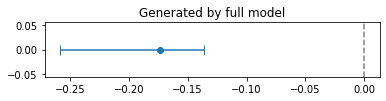

In [6]:
plot_bootstrap(full_boot, "Generated by full model")

In [7]:
nt_boot = bootstrap(nll_data["fit_nt_gen_nt"] - nll_data["fit_full_gen_nt"], np.nanmedian)
nt_boot

array([-0.06472626, -0.04053913,  0.03164438])

<module 'matplotlib.pyplot' from 'C:\\Users\\Timva\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

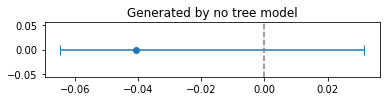

In [8]:
plot_bootstrap(nt_boot, "Generated by no tree model")

In [9]:
def make_plot(data, ref_model_name, referenceModel, compareModel):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 1)

    myFontSize = 12

    loglik_main = -data[referenceModel].mean()
    loglik_diff = []
    loglik_sem  = []
    model_names = [referenceModel, compareModel]
    for model_name in model_names:
        diffs = data[referenceModel] - data[model_name]
        loglik_diff.append(diffs.mean())
        loglik_sem.append(diffs.std() / math.sqrt(len(diffs)))

    domain = [-2.55, -1.9]

    def markSection(ax, label, x, y):
        ax.axhline(y = y-0.5, color='black', linestyle = 'dashed')
        ax.text(x, y, label, ha ='left', va='bottom', fontsize=myFontSize)

    ax.set_ylim([0.5,len(model_names)+0.5])
    ax.set_yticks(range(len(model_names),0,-1))
    ax.set_yticklabels(model_names, fontsize = myFontSize)
    ax.xaxis.set_tick_params(labelsize = myFontSize)
    ax.barh(range(len(model_names),0,-1), loglik_diff,
            xerr = loglik_sem,
            height = 0.5, align='center',
            color = '#7DE3AC', ecolor='black', left=loglik_main)
    ax.plot(loglik_main, len(model_names),'.k')
    ax.axvline(x=loglik_main, color='black')
    markSection(ax, 'Generated by ' + ref_model_name, domain[0], 3)
    # markSection(ax, 'Lesions: features', domain[0], 6)
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(domain)

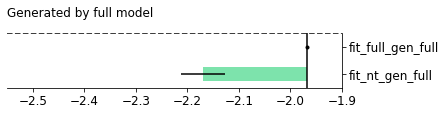

In [10]:
make_plot(nll_data, 'full model', 'fit_full_gen_full', 'fit_nt_gen_full')

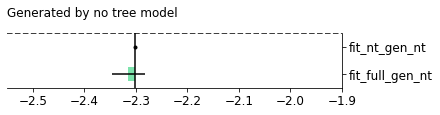

In [11]:
make_plot(nll_data, 'no tree model', 'fit_nt_gen_nt', 'fit_full_gen_nt')